<a href="https://colab.research.google.com/github/Aviv9498/DL2022/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Image Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build a convolutional neural network that can predict
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself.

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.


In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data (20%)

Download the data from https://www.dropbox.com/s/6gdcpmfddojrl8o/data.rar?dl=0.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After you have done so, read this entire section
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair.
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed.
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:


import glob
import numpy as np
import cv2
import os

# Define paths to your data directories
train_data_dir = "/content/gdrive/My Drive/Colab_Notebooks/DL2022/HOMEWORK3/data/data/train"
test_data_w_dir = "/content/gdrive/My Drive/Colab_Notebooks/DL2022/HOMEWORK3/data/data/test_w"
test_data_m_dir = "/content/gdrive/My Drive/Colab_Notebooks/DL2022/HOMEWORK3/data/data/test_m"


# Define the root directory where your data is stored in Google Drive
base_dir = "/content/gdrive/My Drive/Colab_Notebooks/DL2022/HOMEWORK3/data/data"

# Define a function to load and preprocess the data from a specific directory
def load_and_preprocess_data(data_dir):
    data = []

    # Get a list of all image files in the data directory
    image_files = sorted(os.listdir(os.path.join(base_dir, data_dir))) ####for keeping the order within the file, without sorting it got shufled

    triplets = []  # Store triplets here

    for i in range(0, len(image_files), 6):  # Step by 6 to form triplets
        triplet = []  # Store a triplet here
        for j in range(6):
            img_path = os.path.join(base_dir, data_dir, image_files[i + j])
            #print("Image Path:", img_path)  # Print the image path
            img = plt.imread(img_path)
            img = img[:, :, :3]  # Remove the alpha channel if present
            #img = img / 255.0  # Normalize to [0, 1]             ###Apperentely in my computer the images are already normalized, it didnt work otherwise!!!!
            img = img - 0.5  # Center the data around 0
            triplet.append(img)

        # Divide the triplet into pairs
        pairs = [triplet[0:2], triplet[2:4], triplet[4:6]]

        triplets.append(pairs)

    return np.array(triplets)



##loadind np arrays
train_data = load_and_preprocess_data(train_data_dir)
test_data_m = load_and_preprocess_data(test_data_m_dir)
test_data_w = load_and_preprocess_data(test_data_w_dir)

#Deviding Train data into training and Validation out of 678 pics=113 triplets 0f pairs divide to 90 training and 23 validation
valid_data = train_data[90:]
train_data = train_data[:90]

# Save the NumPy arrays to disk
np.save('train_data.npy', train_data)
np.save('valid_data.npy', valid_data)
np.save('test_data_w.npy', test_data_w)
np.save('test_data_m.npy', test_data_m)






In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob
path = "/content/gdrive/My Drive/Colab_Notebooks/DL2022/HOMEWORK3/data/data/test_m/*.jpg" # TODO - UPDATE ME!
images = {}
for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images[filename] = img[:, :, :3] # remove the alpha channel

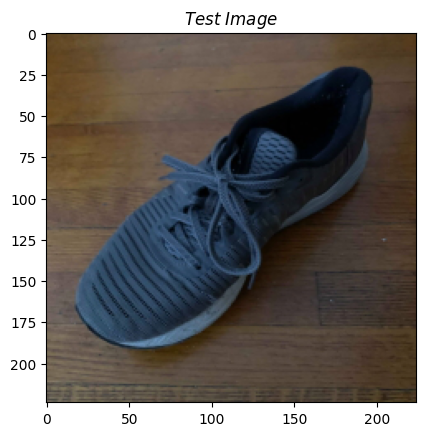

In [ ]:


#Code for uploading the existing np arrays
train_data = np.load('train_data.npy')
valid_data = np.load('valid_data.npy')
image_to_display = (train_data[1,0, 0] + 0.5)  # Example: The left shoe of the first pair of the second person
#image_to_display +=0.5
#image_to_display *= 255
plt.title("$Test$ $Image$")
plt.imshow(image_to_display)
plt.show()







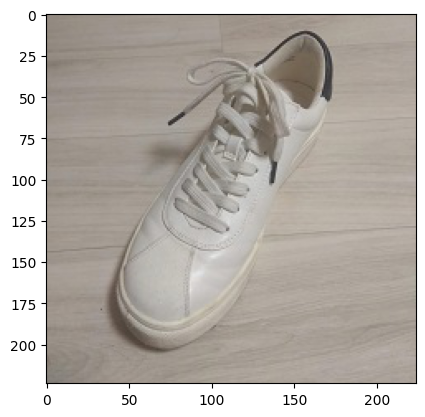

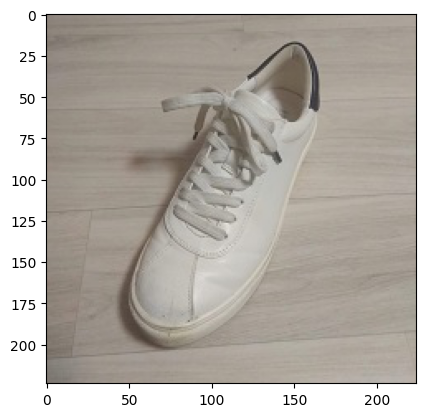

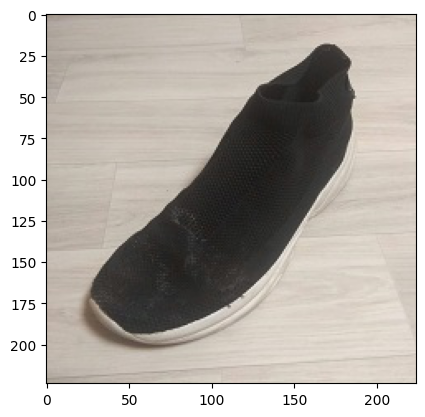

In [ ]:
# Run this code, include the image in your PDF submission

# remember to un-normalize, back to pixels
plt.figure()
plt.imshow((train_data[4,0,0,:,:,:] + 0.5)) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow((train_data[4,0,1,:,:,:]+0.5)) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow((train_data[4,1,1,:,:,:]+0.5)) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

Tests
(90, 3, 2, 224, 224, 3)
(270, 448, 224, 3)


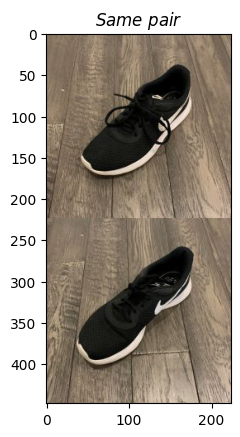

In [ ]:
# Your code goes here
def generate_same_pair(data_set):
  '''
   generates a numpy array where each pair of shoes in the data set is concatenated together.
   In particular, we'll be concatenating together images of left and right shoes along the height axis


    Precondition: np.shape(data_set) = (N,3,2,224,224,3)

    Postcondition: np.shape(same_pair) = (N*3,448,224,3)
           * is number of triplets
  '''
  num_triplets, _, _, height, width, channels = data_set.shape
  same_pair_height = height * 2

  same_pair = np.zeros((num_triplets * 3, same_pair_height, width, channels))

  for i in range(num_triplets):
      for j in range(3):
            left_shoe = data_set[i, j, 0]
            right_shoe = data_set[i, j, 1]
            same_pair[i * 3 + j] = np.vstack((left_shoe, right_shoe)) #Stack both pics in the Height dimention in order to make it 1 pic

  return same_pair


# Run this code, include the result with your PDF submission
print("Tests")
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.title("$Same$ $pair$")
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair, ####Again, Remember to un-normalize

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(90, 3, 2, 224, 224, 3)
(270, 448, 224, 3)


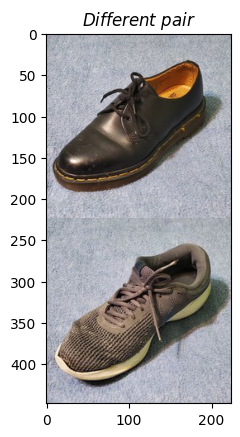

In [ ]:
# Your code goes here
def generate_different_pair(data_set):
  '''
   generates a numpy array where each pair of shoes in the data set is concatenated together.
   In particular, we'll be concatenating together images of left and right shoes along the height axis


    Precondition: np.shape(data_set) = (N,3,2,224,224,3)

    Postcondition: np.shape(same_pair) = (N*3,448,224,3)
           * is number of triplets
  '''
  num_triplets, _, _, height, width, channels = data_set.shape
  different_pair_height = height * 2

  different_pair = np.zeros((num_triplets * 3, different_pair_height, width, channels))

  for i in range(num_triplets):
      triplet = data_set[i]
      # Generate three different combinations of wrong pairs
      for j in range(3):
            # Shuffle the order of the pairs to create different pairs
            shuffled_triplet = np.random.permutation(triplet)
            different_pair[i * 3 + j] = np.vstack((shuffled_triplet[0, 0], shuffled_triplet[1, 1]))
  return different_pair







# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.title("$Different$ $pair$")
plt.imshow(generate_different_pair(train_data)[6]+0.5) # should show 2 shoes from different pairs , ###Again Remember to un-normalize!!!
#print(np.random.permutation(generate_different_pair(train_data)))



### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)





**Write your explanation here:**

The reason is we want to eliminate background "noise" as much as possible.In order to identify pairs correctly we need the only variable that changes to be  the shoe and not different parameters.

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**

than training wont be effective. it will be able to identify correct pairs great but incorrect ones poorly. at the end of the day we need same results in predicting correct pairs and incorrect ones.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

**Explenation :**


our CNN if made of 3 Convolutional layers. each layer has $F_c$ = 5 and Padding = 2 then ReLu activation followed by Max pooling with $F_p = 2$. At the begining our Image is of size $3$×$ 448$×$224.$

after first activation layer size is $D(=3)×H_2(=H_1-F_c+1+2p)×W_2(=W_1-F_c+1=2p) = n×448×224$.


after Max pooling we get $n×224×112$

after second layer we get in the same way as the first $2n×224×112$

after Max pooling we get $2n×112×56$

after third layer we get $4n×112×56$

after Max pooling we get $4n×56×28$

after fourth layer we get $8n×56×28$

after Max pooling we get $8n×28×14$


thats the reason the input for the fully connected layer is $8·n·3·28·14$



In [ ]:
class CNN(nn.Module):
    def __init__(self, n=4 , kernel_size = 5 , hidden_layer = 100):
        super(CNN, self).__init__()
        # TODO: complete this method
        padding = int((kernel_size-1)/2)
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3 , out_channels=n ,kernel_size=kernel_size,padding= padding)
        self.conv2 = nn.Conv2d(in_channels=n,out_channels=2*n,kernel_size=kernel_size,padding=padding)
        self.conv3 = nn.Conv2d(in_channels=2*n,out_channels=4*n,kernel_size=kernel_size,padding=padding)
        self.conv4 = nn.Conv2d(in_channels=4*n , out_channels=8*n,kernel_size=kernel_size,padding = padding )
        self.fc1 = nn.Linear(8*n*28*14,hidden_layer)  #8*n*28*14 is the size of output pic size
        self.fc2 = nn.Linear(hidden_layer,2)

    # TODO: complete this class
    def forward(self,x,verbose = False):
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = self.conv3(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = self.conv4(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = x.view(-1,8*self.n*28*14)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      #x = F.log_softmax(x,dim=1)
      return x










### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n=4 , kernel_size = 5 , hidden_layer = 100):
        super(CNNChannel, self).__init__()
        # TODO: complete this method
        padding = int((kernel_size-1)/2)
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=6 , out_channels=n ,kernel_size=kernel_size,padding= padding)
        self.conv2 = nn.Conv2d(in_channels=n,out_channels=2*n,kernel_size=kernel_size,padding=padding)
        self.conv3 = nn.Conv2d(in_channels=2*n,out_channels=4*n,kernel_size=kernel_size,padding=padding)
        self.conv4 = nn.Conv2d(in_channels=4*n , out_channels=8*n,kernel_size=kernel_size,padding = padding )
        self.fc1 = nn.Linear(8*n*14*14,hidden_layer)  # 8*n*14*14 is the size of output pic size
        self.fc2 = nn.Linear(hidden_layer,2)

    # TODO: complete this class
    def forward(self,x,verbose = False):
      x = torch.cat([x[:,:,:,:224],x[:,:,:,224:]],axis=1)
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = self.conv3(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = self.conv4(x)
      x = F.relu(x)
      x = F.max_pool2d(x,kernel_size=2)
      x = x.view(-1,8*self.n*14*14)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      #x = F.log_softmax(x,dim=1)
      return x
    # TODO: complete this class

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**
We saw in class that Cnns are powerful because they take advantage of the stracucture of images, namely space invarience and locality. is the second Cnn the images are concatenated along the channel axis and pixels are permuted to form a different type of stracture. We antisipate that the first cnn will work better.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, here we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

**Explenation**

The reason is we want to know how the models handles correctly guessing matching pairs and compare it to how the model guesses wrong pairs.
We avaluate False positive and False negetive accs. There are many fields where tracking these are very inportant. One example is the Iron Dome: when the enemmy fires a rocket at us we want to be able to detect it , the number of times a rocket was fired but we couldnt detect it is the false positive. On the other hand when a rocket is fired to an open erea we dont want to set the alarm, so tracking the negative samples are also important. The number of times a rockrt was fired ro an open area but the alarm still went on is the Flase negetive.
our objectiveis to minimize the False positive as much as possible. to aviod a rocket hitting us. We also dont want to set an alarm when there is no need so we also want to minimize the False negative as much as possible.

In [ ]:
def get_accuracy(model, data, batch_size=1 , add_over_all = False):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = (generate_same_pair(data))      # should have shape [n * 3, 448, 224, 3]
    data_neg = (generate_different_pair(data)) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1,3)
        zs = model(xs)
        pred = zs.data.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1,3)
        zs = model(xs)
        pred = zs.data.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    if add_over_all:
        overall_correct = (pos_correct + neg_correct)/(len(data_pos) + len(data_neg))
        return pos_correct / len(data_pos), neg_correct / len(data_neg), overall_correct
    else:
      return pos_correct / len(data_pos),neg_correct / len(data_neg)

    #return pos_correct / (n * 3), neg_correct / (n * 3)

In [ ]:
model = CNN()
pos_acc,neg_acc = get_accuracy(model,valid_data)
print(pos_acc,neg_acc)


1.0 0.0


## Question 3. Training (40%)

Now, we will write the functions required to train the model.

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image.
- computing the forward and backward passes
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [ ]:
# Write your code here
def train_model(model,
                      train_data=train_data,
                      validation_data=valid_data,
                      batch_size=5,
                      learning_rate=0.01,
                      weight_decay=0,
                      epochs=5,
                      checkpoint_path=None , print_interval = 1):
      """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `epochs`
    iterations.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """

      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(),
                           lr = learning_rate
                           ,weight_decay =weight_decay)



      train_losses, val_losses = [], []
      iters_sub, train_accs, val_accs = [], [] ,[]

      n=0
      data_pos = generate_same_pair(train_data)      # should have shape [n * 3, 448, 224, 3]
      data_neg = generate_different_pair(train_data) # should have shape [n * 3, 448, 224, 3]

      best_model = model.state_dict()
      best_loss = 99

      epochs_list = []
      for epoch in range(epochs):
        epoch_losses = []
        correct_count = 0
        count = 0
        if (epoch+1) % print_interval == 0:
          print(f'Epoc: {epoch}')


        model.train()
        #Shufelling the data for batch
        Shufled_data_pos = np.random.permutation(data_pos)
        Shufled_data_neg = np.random.permutation(data_neg)
        half_batch = batch_size//2
        for i in range(0, len(data_pos), batch_size): ##270 training images of pairs concatinated

            if half_batch == 0:
              half_batch=1

            #xt_pos =Shufled_data_pos[i:i+half_batch]
            #xt_neg =Shufled_data_neg[i:i+half_batch]
            #xt = np.concatenate([xt_pos,xt_neg],axis=0)
            #st_pos = np.ones(batch_size//2)
            #st_neg = np.zeros(batch_size//2)
            #st = np.concatenate([st_pos,st_neg],axis=0)

            #Conversion to Tensors   ,,,, in Pytorch and Numpy channel dim is different

            #xt = torch.Tensor(xt).transpose(1, 3)
            #st = torch.Tensor(st).long()


            xt_pos = torch.Tensor(data_pos[i:i + half_batch]).transpose(1, 3)
            xt_neg = torch.Tensor(data_neg[i:i + half_batch]).transpose(1, 3)
            xt = torch.cat([xt_pos, xt_neg])
            x_size = xt.shape[0]
            st = torch.cat([torch.ones(x_size // 2), torch.zeros(x_size // 2)]).to(torch.long)


            #x_size = xt.shape[0]
            #Forward and Backward pass

            zt = model(xt)
            loss = criterion(zt,st)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            probs = F.log_softmax(zt, dim=1)
            preds = torch.argmax(zt, dim=1)
            correct_count += torch.sum(preds == st).item()
            count += preds.shape[0]

            epoch_losses.append(float(loss.item()))

        epoch_training_loss = np.mean(epoch_losses)# compute *average* loss
        train_losses.append(epoch_training_loss)

        with torch.no_grad():
          train_acc_pos, train_acc_neg = get_accuracy(model, train_data)
          train_acc = correct_count / count
          train_accs.append([train_acc_pos, train_acc_neg, train_acc])
          if (epoch+1) % print_interval == 0:
            print(f'TRAINING\t Loss: {epoch_training_loss:.3} Train acc: {train_acc * 100:.3}' )

          val_acc_pos, val_acc_neg, val_acc = get_accuracy(model, validation_data, add_over_all=True)
          val_accs.append([val_acc_pos, val_acc_neg, val_acc])
          if (epoch+1) % print_interval == 0:
            print(f'VALIDATION\t Same Accuracy: {val_acc_pos * 100:.3} Diff Accuracy:{val_acc_neg * 100:.3} '
              f'Val acc: {val_acc * 100:.3}')

        if loss.item() < best_loss:
          best_model = model.state_dict()
          best_loss = loss.item()
      return train_accs, val_accs, best_model






def plot_accuracy(train_acc, val_acc):
  train_same_acc , train_diff_acc, train_acc = zip(*train_acc)
  val_same_acc , val_diff_acc, val_acc = zip(*val_acc)

  x = np.arange(len(train_same_acc))

  plt.figure()
  plt.title('Train Accuracy')
  plt.xlabel('Epocs')
  plt.ylabel('%')
  # plt.plot(x, train_diff_acc, label="different", alpha=0.5)
  # plt.plot(x, train_same_acc, label="same", alpha=0.5)
  plt.plot(x, train_acc, label="all train")
  plt.legend(loc="lower right")
  plt.show()
  plt.figure()
  plt.title('Validation Accuracy')
  plt.xlabel('Epocs')
  plt.ylabel('%')
  plt.plot(x, train_diff_acc, '--', label="different", alpha=0.3)
  plt.plot(x, train_same_acc, '--', label="same", alpha=0.3)
  plt.plot(x, val_acc, label="all validation")
  plt.legend(loc="lower right")
  plt.show()



### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

Epoc: 4
TRAINING	 Loss: 0.693 Train acc: 50.0
VALIDATION	 Same Accuracy: 1e+02 Diff Accuracy:0.0 Val acc: 50.0
Epoc: 9
TRAINING	 Loss: 0.675 Train acc: 56.7
VALIDATION	 Same Accuracy: 53.6 Diff Accuracy:39.1 Val acc: 46.4
Epoc: 14
TRAINING	 Loss: 0.913 Train acc: 46.7
VALIDATION	 Same Accuracy: 87.0 Diff Accuracy:23.2 Val acc: 55.1
Epoc: 19
TRAINING	 Loss: 0.569 Train acc: 80.0
VALIDATION	 Same Accuracy: 53.6 Diff Accuracy:47.8 Val acc: 50.7
Epoc: 24
TRAINING	 Loss: 0.569 Train acc: 80.0
VALIDATION	 Same Accuracy: 71.0 Diff Accuracy:37.7 Val acc: 54.3
Epoc: 29
TRAINING	 Loss: 0.428 Train acc: 86.7
VALIDATION	 Same Accuracy: 85.5 Diff Accuracy:30.4 Val acc: 58.0
Epoc: 34
TRAINING	 Loss: 0.272 Train acc: 90.0
VALIDATION	 Same Accuracy: 87.0 Diff Accuracy:31.9 Val acc: 59.4
Epoc: 39
TRAINING	 Loss: 0.144 Train acc: 90.0
VALIDATION	 Same Accuracy: 81.2 Diff Accuracy:34.8 Val acc: 58.0
Epoc: 44
TRAINING	 Loss: 0.106 Train acc: 93.3
VALIDATION	 Same Accuracy: 81.2 Diff Accuracy:27.5 Val acc:

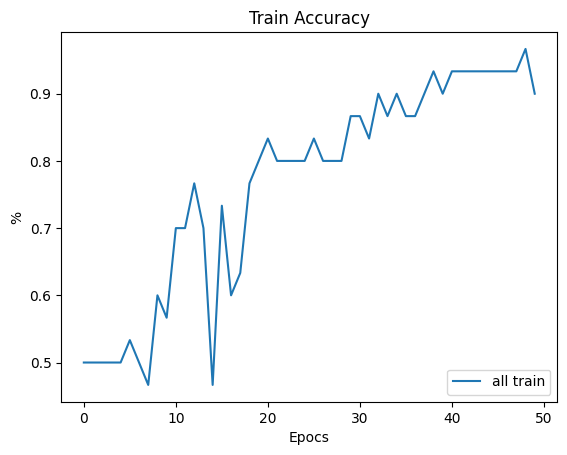

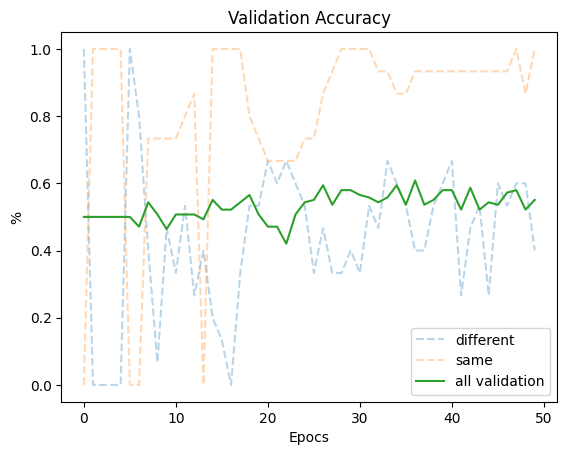

In [ ]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy.

training_parameters_dict = {
                              'model': CNN(n=4, kernel_size=7),
                              'train_data': train_data[:5],
                              'validation_data':valid_data,
                              'batch_size':100,
                              'learning_rate':0.001,
                              'weight_decay':0,
                              'epochs':50,
                              'checkpoint_path':None,
                              'print_interval': 5
                              }

train_acc, val_acc, best_model_CNN = train_model(**training_parameters_dict)
plot_accuracy(train_acc, val_acc)

Epoc: 4
TRAINING	 Loss: 0.683 Train acc: 60.0
VALIDATION	 Same Accuracy: 33.3 Diff Accuracy:79.7 Val acc: 56.5
Epoc: 9
TRAINING	 Loss: 0.539 Train acc: 66.7
VALIDATION	 Same Accuracy: 95.7 Diff Accuracy:17.4 Val acc: 56.5
Epoc: 14
TRAINING	 Loss: 0.424 Train acc: 76.7
VALIDATION	 Same Accuracy: 87.0 Diff Accuracy:53.6 Val acc: 70.3
Epoc: 19
TRAINING	 Loss: 0.302 Train acc: 80.0
VALIDATION	 Same Accuracy: 92.8 Diff Accuracy:50.7 Val acc: 71.7
Epoc: 24
TRAINING	 Loss: 0.198 Train acc: 93.3
VALIDATION	 Same Accuracy: 78.3 Diff Accuracy:62.3 Val acc: 70.3
Epoc: 29
TRAINING	 Loss: 0.123 Train acc: 96.7
VALIDATION	 Same Accuracy: 73.9 Diff Accuracy:60.9 Val acc: 67.4
Epoc: 34
TRAINING	 Loss: 0.0606 Train acc: 96.7
VALIDATION	 Same Accuracy: 71.0 Diff Accuracy:63.8 Val acc: 67.4
Epoc: 39
TRAINING	 Loss: 0.00858 Train acc: 1e+02
VALIDATION	 Same Accuracy: 71.0 Diff Accuracy:53.6 Val acc: 62.3
Epoc: 44
TRAINING	 Loss: 0.000759 Train acc: 1e+02
VALIDATION	 Same Accuracy: 72.5 Diff Accuracy:58.0 

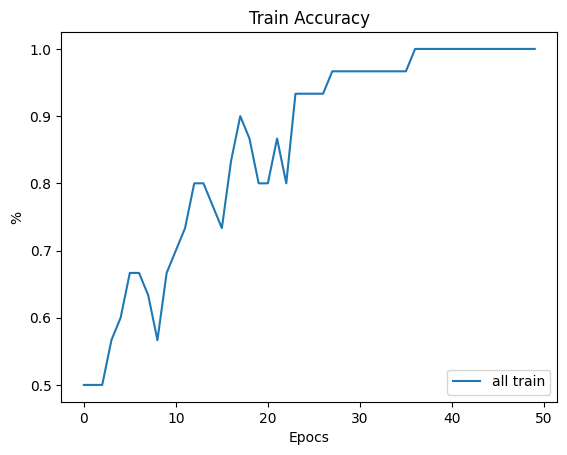

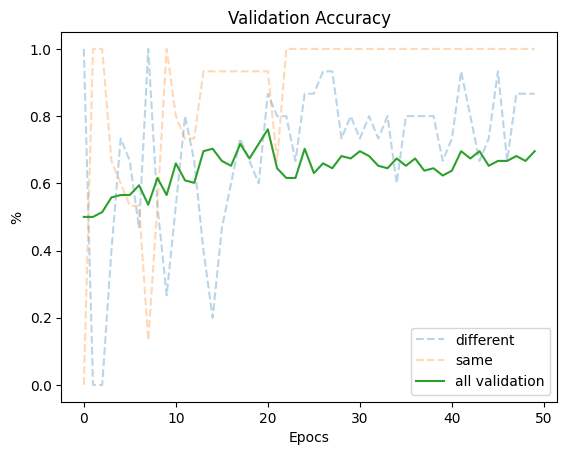

In [ ]:
#Now with CNNChannel

training_parameters_dict = {
                              'model': CNNChannel(n=4, kernel_size=7),
                              'train_data': train_data[:5],
                              'validation_data':valid_data,
                              'batch_size':100,
                              'learning_rate':0.001,
                              'weight_decay':0,
                              'epochs':50,
                              'checkpoint_path':None,
                              'print_interval': 5
                              }

train_acc, val_acc, best_model_CNNChannel = train_model(**training_parameters_dict)
plot_accuracy(train_acc, val_acc)

We can see that for each of the models we got an acc of 100% while the validation didnt change so much. that means the model memorizes the data and not learning. Also worth mentioning that CNNChannel got up to 70% validation acc as opposed to the CNN that got up to around 60%

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few
hyperparameters, including the learning rate, batch size, choice of $n$, and
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**

Epoc: 4
TRAINING	 Loss: 0.694 Train acc: 50.0
VALIDATION	 Same Accuracy: 1e+02 Diff Accuracy:0.0 Val acc: 50.0
Epoc: 9
TRAINING	 Loss: 0.692 Train acc: 53.7
VALIDATION	 Same Accuracy: 52.2 Diff Accuracy:43.5 Val acc: 47.8
Epoc: 14
TRAINING	 Loss: 0.664 Train acc: 63.3
VALIDATION	 Same Accuracy: 85.5 Diff Accuracy:59.4 Val acc: 72.5
Epoc: 19
TRAINING	 Loss: 0.489 Train acc: 77.3
VALIDATION	 Same Accuracy: 73.9 Diff Accuracy:66.7 Val acc: 70.3
Epoc: 24
TRAINING	 Loss: 0.387 Train acc: 85.7
VALIDATION	 Same Accuracy: 94.2 Diff Accuracy:59.4 Val acc: 76.8
Epoc: 29
TRAINING	 Loss: 0.416 Train acc: 85.0
VALIDATION	 Same Accuracy: 97.1 Diff Accuracy:55.1 Val acc: 76.1
Epoc: 34
TRAINING	 Loss: 0.26 Train acc: 88.7
VALIDATION	 Same Accuracy: 94.2 Diff Accuracy:62.3 Val acc: 78.3
Epoc: 39
TRAINING	 Loss: 0.201 Train acc: 90.7
VALIDATION	 Same Accuracy: 92.8 Diff Accuracy:60.9 Val acc: 76.8
Epoc: 44
TRAINING	 Loss: 0.253 Train acc: 90.3
VALIDATION	 Same Accuracy: 85.5 Diff Accuracy:71.0 Val acc: 

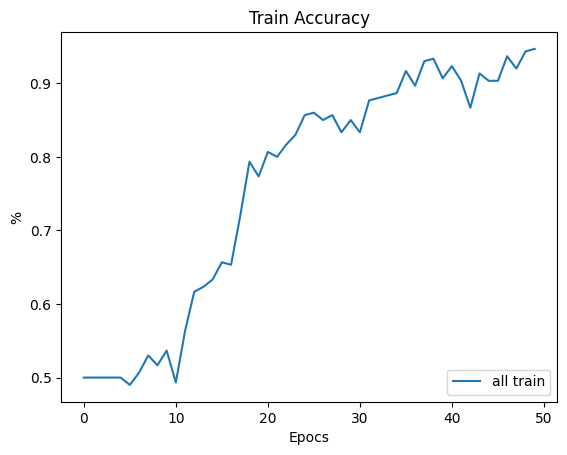

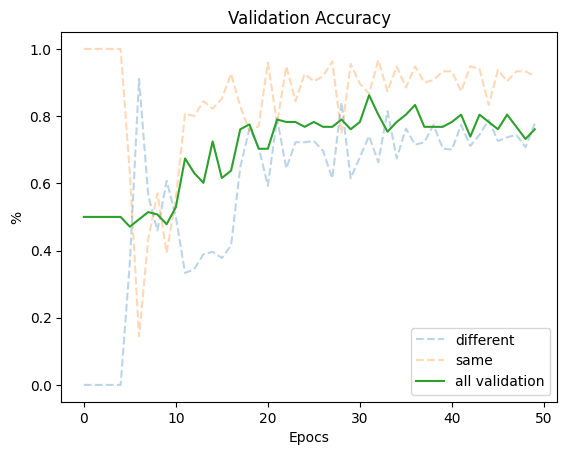

In [ ]:
# Include the training curves for the two models.

training_parameters_dict = {
                              'model': CNN(n=4, kernel_size=7),
                              'train_data': train_data,
                              'validation_data':valid_data,
                              'batch_size':100,
                              'learning_rate':0.001,
                              'weight_decay':0,
                              'epochs':50,
                              'checkpoint_path':None,
                              'print_interval': 5
                              }

train_acc, val_acc, best_model_CNN = train_model(**training_parameters_dict)
plot_accuracy(train_acc, val_acc)

Epoc: 4
TRAINING	 Loss: 0.574 Train acc: 68.7
VALIDATION	 Same Accuracy: 75.4 Diff Accuracy:68.1 Val acc: 71.7
Epoc: 9
TRAINING	 Loss: 0.504 Train acc: 78.3
VALIDATION	 Same Accuracy: 92.8 Diff Accuracy:47.8 Val acc: 70.3
Epoc: 14
TRAINING	 Loss: 0.332 Train acc: 86.3
VALIDATION	 Same Accuracy: 91.3 Diff Accuracy:73.9 Val acc: 82.6
Epoc: 19
TRAINING	 Loss: 0.217 Train acc: 92.0
VALIDATION	 Same Accuracy: 92.8 Diff Accuracy:75.4 Val acc: 84.1
Epoc: 24
TRAINING	 Loss: 0.136 Train acc: 95.3
VALIDATION	 Same Accuracy: 69.6 Diff Accuracy:95.7 Val acc: 82.6
Epoc: 29
TRAINING	 Loss: 0.0791 Train acc: 97.3
VALIDATION	 Same Accuracy: 82.6 Diff Accuracy:75.4 Val acc: 79.0
Epoc: 34
TRAINING	 Loss: 0.129 Train acc: 94.0
VALIDATION	 Same Accuracy: 89.9 Diff Accuracy:85.5 Val acc: 87.7
Epoc: 39
TRAINING	 Loss: 0.136 Train acc: 95.3
VALIDATION	 Same Accuracy: 88.4 Diff Accuracy:68.1 Val acc: 78.3
Epoc: 44
TRAINING	 Loss: 0.0409 Train acc: 99.3
VALIDATION	 Same Accuracy: 82.6 Diff Accuracy:72.5 Val ac

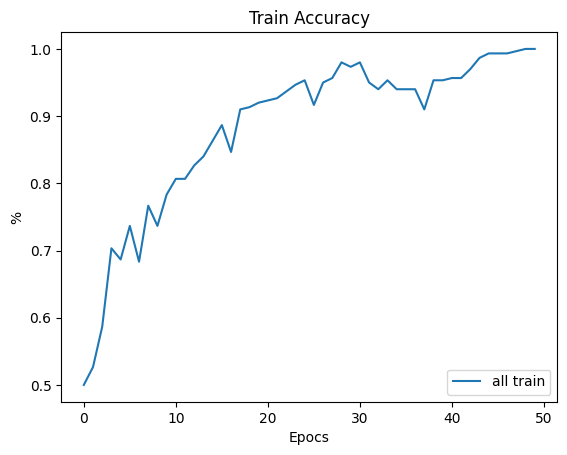

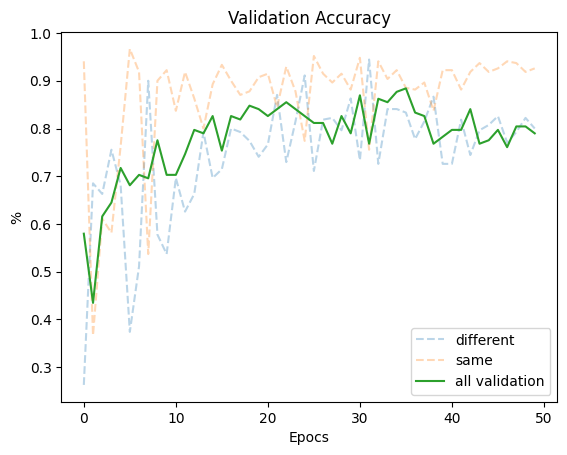

In [ ]:
training_parameters_dict = {
                              'model': CNNChannel(n=4, kernel_size=7),
                              'train_data': train_data,
                              'validation_data':valid_data,
                              'batch_size':100,
                              'learning_rate':0.001,
                              'weight_decay':0,
                              'epochs':50,
                              'checkpoint_path':None,
                              'print_interval': 5
                              }

train_acc, val_acc, best_model_CNNChannel = train_model(**training_parameters_dict)
plot_accuracy(train_acc, val_acc)

In [ ]:
save_models_path = "gdrive/My Drive/Colab_Notebooks/DL2022/HOMEWORK3/data/data"
cnn_model_name = 'CNN_model.pt'
cnn_channel_model_name = 'CNN_Channel_model.pt'


In [ ]:
# save models
torch.save(best_model_CNN, save_models_path + cnn_model_name)
torch.save(best_model_CNNChannel,save_models_path+cnn_channel_model_name)


We found out that increasing the batch size and kernel size helped to improve preformance as well as a 0.0001 learning rate

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [ ]:
# Include the training curves for the two models.

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
from torch.nn.modules import padding
# Write your code here. Make sure to include the test accuracy in your report
cnn_model = CNN(kernel_size=7)
cnn_chan_model = CNNChannel(kernel_size=7)
cnn_model.load_state_dict(torch.load(save_models_path + cnn_model_name))
cnn_chan_model.load_state_dict(torch.load(save_models_path + cnn_channel_model_name))

val_acc_pos, val_acc_neg, val_acc = get_accuracy(cnn_model, test_data_m, add_over_all=True)
print(f'CNN TEST MEN\t Same Accuracy: {val_acc_pos * 100:.3} Diff Accuracy:{val_acc_neg * 100:.3} '
f'Val acc: {val_acc * 100:.3}')
val_acc_pos, val_acc_neg, val_acc = get_accuracy(cnn_model, test_data_w, add_over_all=True)
print(f'CNN TEST WOMEN\t Same Accuracy: {val_acc_pos * 100:.3} Diff Accuracy:{val_acc_neg * 100:.3} '
f'Val acc: {val_acc * 100:.3}')





CNN TEST MEN	 Same Accuracy: 90.0 Diff Accuracy:53.3 Val acc: 71.7
CNN TEST WOMEN	 Same Accuracy: 96.7 Diff Accuracy:63.3 Val acc: 80.0


In [ ]:

val_acc_pos, val_acc_neg, val_acc = get_accuracy(cnn_chan_model, test_data_m, add_over_all=True)
print(f'CNN Channel TEST MEN\t Same Accuracy: {val_acc_pos * 100:.3} Diff Accuracy:{val_acc_neg * 100:.3} '
f'Val acc: {val_acc * 100:.3}')
val_acc_pos, val_acc_neg, val_acc = get_accuracy(cnn_chan_model, test_data_w, add_over_all=True)
print(f'CNN Channel TEST WOMEN\t Same Accuracy: {val_acc_pos * 100:.3} Diff Accuracy:{val_acc_neg * 100:.3} '
f'Val acc: {val_acc * 100:.3}')


CNN Channel TEST MEN	 Same Accuracy: 90.0 Diff Accuracy:63.3 Val acc: 76.7
CNN Channel TEST WOMEN	 Same Accuracy: 90.0 Diff Accuracy:73.3 Val acc: 81.7


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

Guessed wrong! the shoes are of Same pair, the model thought otherwise


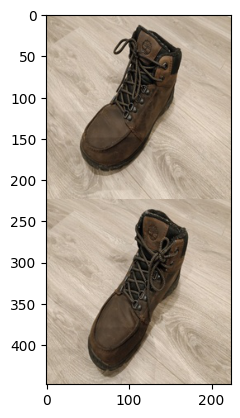

In [ ]:

same_pair_m = generate_same_pair(test_data_m)
single_pair = same_pair_m[:1]
xs = torch.Tensor(same_pair_m[:10]).transpose(1, 3)
zs = cnn_chan_model(xs)
preds = torch.argmax(zs, dim=1)
for idx, pred in enumerate(preds):
  if pred.item() == 0:
    print('Guessed wrong! the shoes are of Same pair, the model thought otherwise')
    plt.figure()
    plt.imshow(same_pair_m[idx] + 0.5)
    plt.show()
    break


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

Guessed wrong! the shoes are of different pairs, the model thought otherwise


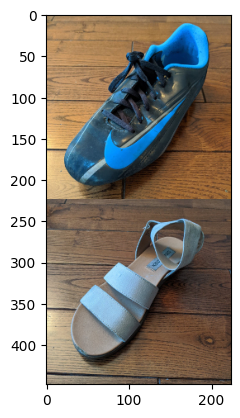

In [ ]:
same_pair_w = generate_different_pair(test_data_w)
xs = torch.Tensor(same_pair_w[10:20]).transpose(1, 3)
zs = cnn_chan_model(xs)
preds = torch.argmax(zs, dim=1)
for idx, pred in enumerate(preds):
  if pred.item() == 1:

    print('Guessed wrong! the shoes are of different pairs, the model thought otherwise')
    plt.figure()
    plt.imshow(same_pair_w[idx] + 0.5)
    plt.show()
    break
